<a href="https://colab.research.google.com/github/muhiqbalalamin/DeepLearning/blob/main/ReviewTokoBaju_Pytorch.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Pytorch

In [ ]:
!pip install torch torchvision

In [1]:
import re
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, TensorDataset
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from collections import Counter

In [2]:
# Load and Preprocess Dataset
url = "https://raw.githubusercontent.com/farrelrassya/teachingMLDL/1a62c814ab2a0a1c080e04391824de60a70e76e0/02.%20Deep%20Learning/05.%20Week%205/Datasets/ReviewTokoBaju.csv"
df = pd.read_csv(url)
df.columns = df.columns.str.strip()
df = df.rename(columns={"Review Text": "review", "Recommended IND": "label"})
df.dropna(inplace=True)

def clean_text(text):
    text = text.lower()
    text = re.sub(r"[^a-zA-Z0-9\s]", "", text)
    return text

df['cleaned_review'] = df['review'].astype(str).apply(clean_text)
df = df[df['cleaned_review'].str.strip() != ""]

all_words = ' '.join(df['cleaned_review']).split()
vocab = {word: idx + 2 for idx, (word, _) in enumerate(Counter(all_words).items())}
vocab['<PAD>'] = 0
vocab['<UNK>'] = 1

max_length = 100

def encode_review(text, vocab, max_len=max_length):
    tokens = text.split()
    encoded = [vocab.get(word, vocab['<UNK>']) for word in tokens]
    if len(encoded) < max_len:
        encoded += [vocab['<PAD>']] * (max_len - len(encoded))
    return encoded[:max_len]

encoded_reviews = [encode_review(text, vocab) for text in df['cleaned_review']]
labels = df['label'].astype(int).tolist()

X_train, X_test, y_train, y_test = train_test_split(
    encoded_reviews, labels, test_size=0.2, stratify=labels, random_state=42
)

X_train_tensor = torch.tensor(X_train, dtype=torch.long)
X_test_tensor = torch.tensor(X_test, dtype=torch.long)
y_train_tensor = torch.tensor(y_train, dtype=torch.float32).view(-1, 1)
y_test_tensor = torch.tensor(y_test, dtype=torch.float32).view(-1, 1)

train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
test_dataset = TensorDataset(X_test_tensor, y_test_tensor)
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=64)

In [3]:
# Model Definitions
class SentimentRNN(nn.Module):
    def __init__(self, vocab_size, hidden_dim, output_dim=1):
        super().__init__()
        self.embedding = nn.Embedding(vocab_size, 128)
        self.rnn = nn.RNN(128, hidden_dim, batch_first=True)
        self.fc = nn.Linear(hidden_dim, output_dim)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        x = self.embedding(x)
        _, hidden = self.rnn(x)
        out = self.fc(hidden.squeeze(0))
        return self.sigmoid(out)

class SentimentLSTM(nn.Module):
    def __init__(self, vocab_size, hidden_dim, output_dim=1):
        super().__init__()
        self.embedding = nn.Embedding(vocab_size, 128)
        self.lstm = nn.LSTM(128, hidden_dim, batch_first=True)
        self.fc = nn.Linear(hidden_dim, output_dim)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        x = self.embedding(x)
        _, (hidden, _) = self.lstm(x)
        out = self.fc(hidden.squeeze(0))
        return self.sigmoid(out)

class SentimentGRU(nn.Module):
    def __init__(self, vocab_size, hidden_dim, output_dim=1):
        super().__init__()
        self.embedding = nn.Embedding(vocab_size, 128)
        self.gru = nn.GRU(128, hidden_dim, batch_first=True)
        self.fc = nn.Linear(hidden_dim, output_dim)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        x = self.embedding(x)
        _, hidden = self.gru(x)
        out = self.fc(hidden.squeeze(0))
        return self.sigmoid(out)

In [4]:
# Training Function
def train_model(model, train_loader, val_loader, epochs=10, lr=0.001):
    criterion = nn.BCELoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    train_loss, val_loss = [], []

    for epoch in range(epochs):
        model.train()
        total_loss = 0
        for inputs, labels in train_loader:
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            total_loss += loss.item()

        train_loss.append(total_loss / len(train_loader))

        model.eval()
        total_val_loss = 0
        with torch.no_grad():
            for inputs, labels in val_loader:
                outputs = model(inputs)
                loss = criterion(outputs, labels)
                total_val_loss += loss.item()
        val_loss.append(total_val_loss / len(val_loader))

        print(f"Epoch {epoch+1}/{epochs} - Train Loss: {train_loss[-1]:.4f} - Val Loss: {val_loss[-1]:.4f}")

    # Plot Loss Curve
    plt.plot(train_loss, label="Train")
    plt.plot(val_loss, label="Validation")
    plt.legend()
    plt.show()

    return model

In [5]:
# Evaluation Function
def evaluate(model, loader):
    model.eval()
    y_true, y_pred = [], []
    with torch.no_grad():
        for inputs, labels in loader:
            outputs = model(inputs)
            predictions = (outputs > 0.5).float()
            y_true.extend(labels.cpu().numpy())
            y_pred.extend(predictions.cpu().numpy())

    acc = accuracy_score(y_true, y_pred)
    prec = precision_score(y_true, y_pred)
    rec = recall_score(y_true, y_pred)
    f1 = f1_score(y_true, y_pred)
    print(f"Accuracy: {acc:.4f}, Precision: {prec:.4f}, Recall: {rec:.4f}, F1: {f1:.4f}")

Epoch 1/10 - Train Loss: 0.4828 - Val Loss: 0.4725
Epoch 2/10 - Train Loss: 0.4731 - Val Loss: 0.4723
Epoch 3/10 - Train Loss: 0.4692 - Val Loss: 0.4754
Epoch 4/10 - Train Loss: 0.4644 - Val Loss: 0.4740
Epoch 5/10 - Train Loss: 0.4578 - Val Loss: 0.4804
Epoch 6/10 - Train Loss: 0.4509 - Val Loss: 0.4832
Epoch 7/10 - Train Loss: 0.4427 - Val Loss: 0.5048
Epoch 8/10 - Train Loss: 0.4483 - Val Loss: 0.4894
Epoch 9/10 - Train Loss: 0.4357 - Val Loss: 0.4994
Epoch 10/10 - Train Loss: 0.4308 - Val Loss: 0.5037


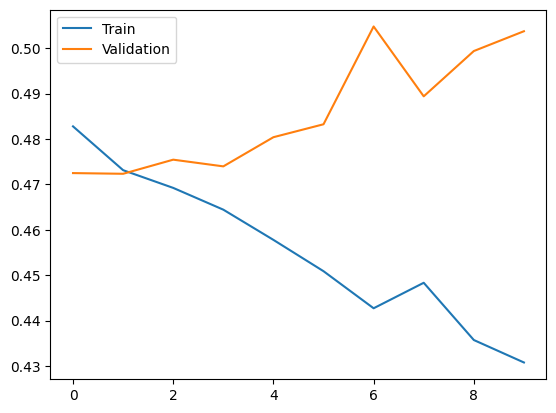

Accuracy: 0.8116, Precision: 0.8198, Recall: 0.9866, F1: 0.8955


In [6]:
# Run Model
# RNN
model_rnn = SentimentRNN(len(vocab), hidden_dim=64)
model_rnn = train_model(model_rnn, train_loader, test_loader)
evaluate(model_rnn, test_loader)

Epoch 1/10 - Train Loss: 0.4827 - Val Loss: 0.4731
Epoch 2/10 - Train Loss: 0.4724 - Val Loss: 0.4733
Epoch 3/10 - Train Loss: 0.4385 - Val Loss: 0.3712
Epoch 4/10 - Train Loss: 0.3138 - Val Loss: 0.3624
Epoch 5/10 - Train Loss: 0.2416 - Val Loss: 0.2926
Epoch 6/10 - Train Loss: 0.1963 - Val Loss: 0.2842
Epoch 7/10 - Train Loss: 0.1677 - Val Loss: 0.3039
Epoch 8/10 - Train Loss: 0.1387 - Val Loss: 0.3045
Epoch 9/10 - Train Loss: 0.1114 - Val Loss: 0.3469
Epoch 10/10 - Train Loss: 0.0903 - Val Loss: 0.3790


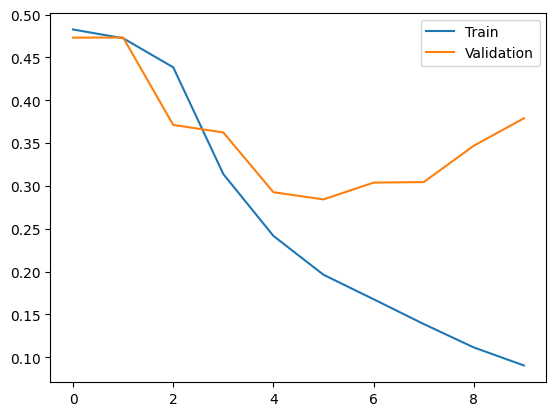

Accuracy: 0.8785, Precision: 0.9202, Recall: 0.9323, F1: 0.9262


In [8]:
# LSTM
model_lstm = SentimentLSTM(len(vocab), hidden_dim=64)
model_lstm = train_model(model_lstm, train_loader, test_loader)
evaluate(model_lstm, test_loader)

Epoch 1/10 - Train Loss: 0.4665 - Val Loss: 0.3946
Epoch 2/10 - Train Loss: 0.3173 - Val Loss: 0.2795
Epoch 3/10 - Train Loss: 0.2298 - Val Loss: 0.2848
Epoch 4/10 - Train Loss: 0.1825 - Val Loss: 0.2989
Epoch 5/10 - Train Loss: 0.1445 - Val Loss: 0.3102
Epoch 6/10 - Train Loss: 0.1120 - Val Loss: 0.3235
Epoch 7/10 - Train Loss: 0.0827 - Val Loss: 0.3385
Epoch 8/10 - Train Loss: 0.0601 - Val Loss: 0.4005
Epoch 9/10 - Train Loss: 0.0546 - Val Loss: 0.4530
Epoch 10/10 - Train Loss: 0.0379 - Val Loss: 0.4705


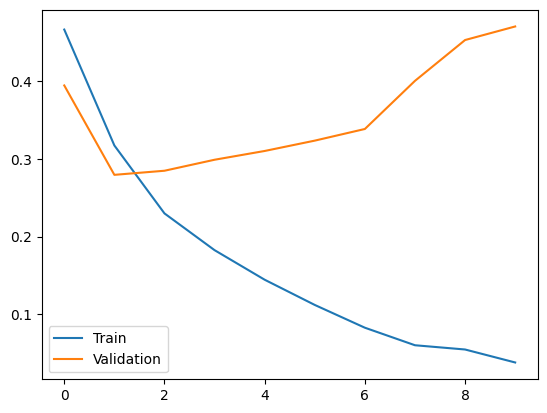

Accuracy: 0.8767, Precision: 0.9201, Recall: 0.9301, F1: 0.9251


In [9]:
# GRU
model_gru = SentimentGRU(len(vocab), hidden_dim=64)
model_gru = train_model(model_gru, train_loader, test_loader)
evaluate(model_gru, test_loader)